# Tutorial4: Convolutional Layers - Spectral methods

## Outline

- Why convolution in ML
- Some theory on convolution
- Convolution on graphs
- Spectral-convolutional layers in PyTorch Geometric

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0


/home/antonio/anaconda3/envs/geometric_new/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

## Why convolution in ML

- Weight sharing
- Detection of translational invariant and local features

![](fig/fully_connected.png)
[Source](https://missinglink.ai/guides/convolutional-neural-networks/fully-connected-layers-convolutional-neural-networks-complete-guide/)

![](fig/cnn.gif)
[Source](https://commons.wikimedia.org/wiki/File:Convolutional_Neural_Network.gif)

![](fig/Convolution.png)
[Source](https://commons.wikimedia.org/wiki/File:Convolution.PNG)

## Some theory on convolution

![](fig/Convolution_of_box_signal_with_itself2.gif)
[Source](https://en.wikipedia.org/wiki/File:Convolution_of_box_signal_with_itself2.gif)

### Definition

\begin{align*}
c[n] = (v * w)[n] = \sum_{m=0}^{N-1} v[m] \cdot w[n-m]
\end{align*}

In [3]:
def conv(v, w):
    c = np.zeros(v.shape)
    for n in range(len(v)):
        c[n] = 0
        for m in range(len(v)):
            c[n] += v[m] * w[n - m]  
    return c

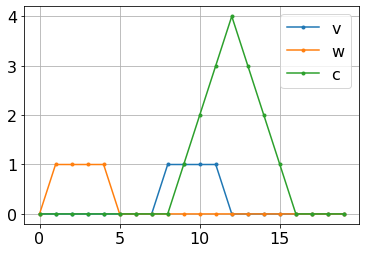

In [4]:
N = 20
v = np.zeros(N)
v[8:12] = 1
w = np.zeros(N)
w[1:5] = 1
c = conv(v, w)

fig = plt.figure()
ax = fig.gca()
ax.plot(v, '.-')
ax.plot(w, '.-')
ax.plot(c, '.-')
ax.legend(['v', 'w', 'c'])
ax.grid(True)

### Fourier transform

Transformation $\mathcal F: \mathbb{R}^N \to \mathbb{R}^N$ with

\begin{align*}
\mathcal F^{-1}(\mathcal F (v)) &= v\\
\mathcal F(v * w) &= \mathcal F(v) \cdot \mathcal F(w).
\end{align*}

This implies
\begin{align*}
v * w &= \mathcal F^{-1}(\mathcal F (v * w))\\
&= \mathcal F^{-1}(\mathcal F(v) \cdot \mathcal F(w))
\end{align*}

In [5]:
v, w = np.random.rand(N), np.random.rand(N)
conv(v, w)

array([4.75972857, 3.84267706, 4.75547361, 4.69473343, 4.41980675,
       4.38291796, 3.98819354, 4.36896188, 4.0910097 , 4.60256767,
       4.9724941 , 5.12207561, 5.60658149, 4.99165311, 4.75559415,
       4.99484192, 4.8482739 , 4.82087932, 4.5831123 , 4.63790021])

In [6]:
from scipy.fft import fft, ifft # Fast Fourier Transform / Inverse FFT
np.abs(ifft(fft(v) * fft(w)))

array([4.75972857, 3.84267706, 4.75547361, 4.69473343, 4.41980675,
       4.38291796, 3.98819354, 4.36896188, 4.0910097 , 4.60256767,
       4.9724941 , 5.12207561, 5.60658149, 4.99165311, 4.75559415,
       4.99484192, 4.8482739 , 4.82087932, 4.5831123 , 4.63790021])

### Definition of the Fourier transform

The Fourier transform can be computed as

\begin{align*}
\mathcal F(v) = U\cdot v, \;\;\mathcal F^{-1}(v) = \frac{1}{N}\ U^H \cdot v
\end{align*}

where the $N\times N$ matrix $U$ is defined as
\begin{align*}
\\
U = 
\begin{bmatrix}
u_0(0) & u_1(0) & \dots & u_{N-1}(0)\\
u_0(1) & u_1(1) & \dots & u_{N-1}(1)\\
\vdots & \vdots& & \vdots\\
u_0(N-1) & u_1(N-1) & \dots & u_{N-1}(N-1)\\
\end{bmatrix} 
\end{align*}

and $u_0, \dots, u_{N-1}$ are functions defined as

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right).
\end{align*}

In [7]:
def matrix_U(N):
    u = lambda n, N: np.cos(2 * np.pi / N * n * np.arange(N)) - 1j * np.sin(2 * np.pi / N * n * np.arange(N))
    U = np.empty((N, 0))
    for n in range(N):
        U = np.c_[U, u(n, N)]
    return U


def fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return U @ v


def inverse_fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return (U.conj().transpose() @ v) / N

In [8]:
fft(v) - fourier_transform(v)

array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-2.22044605e-16j,
        7.77156117e-16+0.00000000e+00j,  2.22044605e-16+1.05471187e-15j,
        2.22044605e-16+6.10622664e-16j,  1.99840144e-15-6.66133815e-16j,
       -1.11022302e-15-4.44089210e-16j, -2.83106871e-15-1.11022302e-16j,
       -4.44089210e-16+1.60982339e-15j, -1.33226763e-15+4.44089210e-16j,
        8.88178420e-16+3.88387152e-16j,  2.88657986e-15-3.55271368e-15j,
        4.44089210e-16+4.99600361e-16j, -4.27435864e-15-1.66533454e-15j,
       -2.66453526e-15+3.44169138e-15j,  6.21724894e-15-1.11022302e-15j,
       -6.66133815e-16+1.60982339e-15j,  2.22044605e-16-1.44328993e-15j,
        1.44328993e-15+4.32986980e-15j, -9.99200722e-16+2.22044605e-16j])

In [9]:
ifft(v) - inverse_fourier_transform(v)

array([ 5.55111512e-17-0.00000000e+00j,  0.00000000e+00-4.16333634e-17j,
        4.51028104e-17-1.38777878e-17j,  1.38777878e-17-5.55111512e-17j,
       -1.73472348e-18-1.73472348e-17j,  8.32667268e-17+1.38777878e-17j,
       -5.55111512e-17+2.42861287e-17j, -1.38777878e-16+0.00000000e+00j,
       -5.55111512e-17-8.67361738e-17j, -5.55111512e-17-2.77555756e-17j,
        6.93889390e-18-1.94193576e-17j,  1.45716772e-16+1.87350135e-16j,
        0.00000000e+00-3.12250226e-17j, -2.27248775e-16+9.71445147e-17j,
       -1.24900090e-16-1.70002901e-16j,  2.91433544e-16+5.55111512e-17j,
       -3.29597460e-17-8.32667268e-17j,  0.00000000e+00+6.93889390e-17j,
        7.28583860e-17-2.22044605e-16j, -6.59194921e-17+5.55111512e-17j])

### Connection with the Laplacian

The functions $u_n$ (the columns of the Fourier transform matrix) are eigenvectors of the Laplacian:

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right)\\
\Delta u_n(x)&:= \left(-4 \pi ^ 2\frac{n^2}{N^2}\right) u_n(x)
\end{align*}

### Summary

\begin{align*}
v * w 
= U^H ((U  w) \odot (U  v))
\end{align*}

or if $g_w=\mbox{diag}(U w)$ is  filter
\begin{align*}
v * w 
= U^H g_w U  w
\end{align*}

In [10]:
U = matrix_U(N)
np.abs((U.conj().transpose() / N) @ ((U @ v) * (U @ w)))

array([4.75972857, 3.84267706, 4.75547361, 4.69473343, 4.41980675,
       4.38291796, 3.98819354, 4.36896188, 4.0910097 , 4.60256767,
       4.9724941 , 5.12207561, 5.60658149, 4.99165311, 4.75559415,
       4.99484192, 4.8482739 , 4.82087932, 4.5831123 , 4.63790021])

In [11]:
conv(v, w)

array([4.75972857, 3.84267706, 4.75547361, 4.69473343, 4.41980675,
       4.38291796, 3.98819354, 4.36896188, 4.0910097 , 4.60256767,
       4.9724941 , 5.12207561, 5.60658149, 4.99165311, 4.75559415,
       4.99484192, 4.8482739 , 4.82087932, 4.5831123 , 4.63790021])

## Convolution on graphs

**Plan**:
    - Define the graph Laplacian
    - Compute the spectrum
    - Define a Fourier transform
    - Define convolution on a graph

**Note:** From now on $G = (V, E)$ is an undirected, unweighted, simple graph.

### Graph Laplacian

Adjacency matrix
\begin{align*}
A_{ij} = \left\{
    \begin{array}{ll}
    1 &\text{ if } e_{ij}\in E\\
    0 &\text{ if } e_{ij}\notin E
    \end{array}
    \right.
\end{align*}

Degree matrix
\begin{align*}
D_{ij} = \left\{
    \begin{array}{ll}
    \mbox{deg}(v_i) &\text{ if } i=j\\
    0 &\text{ if } i\neq j
    \end{array}
    \right.
\end{align*}

Laplacian
\begin{align*}
L &= D - A.
\end{align*}

Normalized Laplacian
\begin{align*}
L &= I - D^{-1/2} A D^{-1/2}.
\end{align*}

### Graph spectrum, Fourier transform, and convolution

1. Spectral decomposition of the Laplacian:
\begin{align*}
L = U \Lambda U^T\\
\end{align*}


2. Fourier transform: if $v$ is a vector of features on the graph, then
\begin{align*}
\mathcal F (v) = U \cdot v, \;\;\mathcal F^{-1} (v) = U^T \cdot v\\
\end{align*}


3. Convolution with a filter $U \cdot w$
\begin{align*}
v * w = U ((U^T  w) \odot (U^T  v) )
\end{align*}


Or $g_w = \mbox{diag}(U^T w)$ is a filter, then
\begin{align*}
v * w = U g_w U^T  v
\end{align*}


## Spectral-convolutional layers in PyTorch Geometric

**Problem:** Computing the spectrum is a global and very expensive property.

**Goal:** Implementation as message passing.

### ChebConv

- Original [paper](https://arxiv.org/pdf/1606.09375.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.ChebConv)

#### Goal: 
Compute $U g_w U^T x$ with $g_w = g_w(\Lambda)$ a filter.

#### Chebyshev approximation

Chebyshev polynomials $T_k$:
\begin{align*}
T_{k}(x) = 2 x T_{k-1}(x) - T_{k-2}(x), \;\; T_0(x) = 1, T_1(x) = x
\end{align*}

#### Chebyshev approximation of the filter
Aproximation of the filter:
\begin{align*}
g_w(\Lambda) = \sum_{k=0}^K \theta_k T_k(\tilde \Lambda),\;\;\;\;\tilde \Lambda = \frac{2}{\lambda_\max} \Lambda - I
\end{align*}


#### Property
If $L = U \Lambda U^T$ then $T_k(L) = U T_k(\Lambda) U^T$.


#### Fast approximated convolution 
\begin{align*}
v * w &= U g_w U^T x
= U \left(\sum_{k=0}^K \theta_k T_k(\tilde \Lambda) \right)U^T x
=\sum_{k=0}^K  \theta_k U  T_k(\tilde \Lambda) U^T x\\ 
&=\sum_{k=0}^K  \theta_k T_k(\tilde L) x 
\end{align*}

\begin{align*}
\tilde L = \frac{2}{\lambda_\max} L - I
\end{align*}

#### Properties:
- Depends on $L$ and $\lambda_\max$, not on $U, \Sigma$
- Uses only $K$-powers $\Rightarrow$ only the $K$-th neighborhood of each node, localized filter

**As message passing:**
![](fig/cheb_init.png)

![](fig/cheb_norm.png)

![](fig/cheb_forward.png)

![](fig/cheb_message.png)

### GCNConv

- Original [paper](https://arxiv.org/pdf/1609.02907.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)

Start from `ChebConv` and assume 
1. $K=1$ (linear approximation) so
\begin{align*}
v * w 
&=\sum_{k=0}^1  \theta_k T_k(\tilde L) x
= \theta_0 x + \theta_1 \tilde L x\\
\end{align*}

2. $\lambda_\max =2$ so
\begin{align*}
v * w 
&= \theta_0 x + \theta_1 (L - I) x\\
&= \theta_0 x - \theta_1 D^{-1/2} A D^{1/2} x\\
\end{align*}


3. $\theta_0=-\theta_1= \theta$ so 
\begin{align*}
v * w = \left(I + D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

4. Renormalization of $\theta$ by using 
\begin{align*}
\tilde A&:= I + A\\
\tilde D_{ii}&:= \sum_j \tilde A_{ij}
\end{align*}
so 
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

If $x$ is a $F$-dimensional feature vector, and we want an $F'$-dimensional feature vector as output:
use $W'\in \mathbb{R}^{F\times F'}$
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \Theta
\end{align*}


Nodewise:
    ![image.png](fig/gcn_nodewise.png)

#### As message passing
See Tutorial3